# Topic Modeling

Topic modeling is the umbrella term for several statistical methods that show coocurrences of groups of words irrespective of their positions in the text. These groups, or "topics," are computationally inferred probabilistically, not semantically, and so even though they are called topics, they don't always correspond to what we would consider a topic. 

A good, general-purpose introduction to topic modeling [can be found here](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf) via David Blei's website.

Topic modeling is very sensitive to lots of factors. First, it works best on many documents rather than just a few, since a topic is defined as that which is distributed across documents. So it's a good idea to break a text into equal-sized chunks, first. 

I'll start by defining a `chunk()` function to do that, to break up a text into equal-sized chunks of about 500 words each. 

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
from more_itertools import chunked
from nltk import word_tokenize
from nltk.corpus import brown
import pyLDAvis.sklearn 
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
def chunk(tokens, size): 
    return list(zip(*[tokens[i::size] for i in range(size)])) 

In [3]:
moonstone = open('../moonstone.md').read()

In [4]:
moonstoneParts = moonstone.split('%%%%%')

In [5]:
moonstoneTokens = word_tokenize(moonstone)

In [6]:
moonstoneChunks = chunk(moonstoneTokens, 300)

Now I'll join the words together, to make strings again. 

In [7]:
moonstoneChunks = [' '.join(chunk) for chunk in moonstoneChunks]

Sanity check: how many chunks do we have? 

In [8]:
len(moonstoneChunks)

780

And what is the length (in characters) of each one? 

In [9]:
[len(chunk) for chunk in moonstoneChunks[:10]]

[1575, 1580, 1595, 1544, 1451, 1388, 1335, 1459, 1400, 1440]

Now we'll use a CountVectorizer instead of the TfidfVectorizer, to get word counts, rather than frequencies (LDA works best on counts). We'll say that we only want to see words that appear in at least 5% of documents, and in no more than 80% of documents. We'll also ignore stopwords while we're at it ("a," "the," "of," etc.). 

In [10]:
cv = CountVectorizer(min_df=2, max_df=0.95, stop_words='english')

Fit our model and transform our chunks into counts: 

In [11]:
counts = cv.fit_transform(moonstoneChunks)

In [12]:
counts

<780x5111 sparse matrix of type '<class 'numpy.int64'>'
	with 62923 stored elements in Compressed Sparse Row format>

Now we can get a list of all the words used here. Let's also peek at them, so that we know we're using content words, and not function words: 

In [13]:
wordLabels = cv.get_feature_names()

In [14]:
wordLabels[200:210]

['apartments',
 'aperture',
 'apologies',
 'apologise',
 'apology',
 'apparently',
 'apparition',
 'appeal',
 'appealed',
 'appealing']

Looks OK. Initialize our LDA engine: 

In [15]:
lda = LatentDirichletAllocation(n_topics=5, learning_method='online')

And do the topic modeling itself: 

In [16]:
ldaOut = lda.fit_transform(counts)

In [17]:
ldaOut.shape

(780, 5)

In [18]:
ldaOut

array([[ 0.00193757,  0.00195848,  0.00189769,  0.99224762,  0.00195865],
       [ 0.60464474,  0.17453547,  0.00195878,  0.00197358,  0.21688743],
       [ 0.59462853,  0.00192499,  0.0018737 ,  0.00189827,  0.39967451],
       ..., 
       [ 0.00190104,  0.00189753,  0.00188777,  0.0018994 ,  0.99241426],
       [ 0.00211896,  0.00212599,  0.00210611,  0.00211984,  0.99152911],
       [ 0.00205859,  0.00205523,  0.00204111,  0.00205524,  0.99178984]])

Now we can print the results from our model's `.components_` property: 

In [22]:
topicLabels = []
for i, topic in enumerate(lda.components_):
    print("Topic {}".format(i))
    topicLabel = " ".join([wordLabels[i] for i in topic.argsort()[:-10 - 1:-1]])
    print(topicLabel)
    topicLabels.append(topicLabel)

Topic 0
hindoo kattiawar time called north sacred wild india quicksand century
Topic 1
mr said franklin time sergeant miss rachel room house say
Topic 2
property mothers tract small committee clothes books mission societies dear
Topic 3
mr day place miss blake luker godfrey way know franklin
Topic 4
indians men time shrine ship steamer left people place mr


...or we can import this into a Pandas DataFrame so we can see how these topics show up in narrative time: 

In [25]:
df = pd.DataFrame(ldaOut, columns=topicLabels)

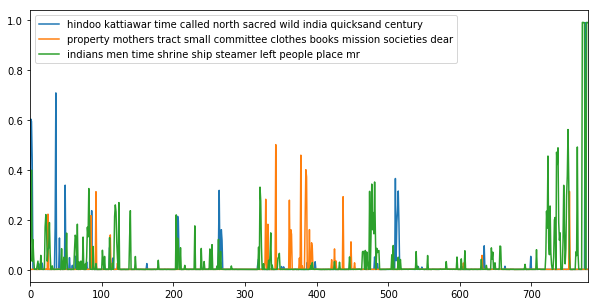

In [40]:
df[[topicLabels[0], topicLabels[2], topicLabels[4]]].plot()

Let's do the same thing again, but tweak the parameters a bit, and put it all into a function, so that it'll be easily reproducible.

In [71]:
def topicModel(docs, numTopics=8, numWords=8, maxFeats=None): 
    cv = CountVectorizer(stop_words='english', 
                         min_df=0.1, max_df=0.9, max_features=maxFeats)
    counts = cv.fit_transform(docs)
    wordLabels = cv.get_feature_names()
    lda = LatentDirichletAllocation(n_topics=numTopics, max_iter=10, 
                                    learning_method='online',
                                    learning_offset=50., random_state=0)
    lda.fit_transform(counts)
    for i, topic in enumerate(lda.components_):
        print("Topic {}".format(i))
        print(" ".join([wordLabels[i] for i in topic.argsort()[:-numWords - 1:-1]]))
    return lda, counts, cv

And let's try the same thing, but with the Brown corpus category "news," which will work a little better for topic modeling: 

In [72]:
newsWords = list(brown.words(categories='news'))

In [73]:
len(newsWords)

100554

In [74]:
type(newsWords)

list

In [75]:
chunks = [' '.join(chunk) for chunk in chunk(newsWords, 400)]

In [76]:
len(chunks)

251

In [77]:
[len(c) for c in chunks[:10]]

[2282, 2329, 2110, 2274, 2216, 2209, 2203, 2184, 2176, 2154]

In [78]:
lda, counts, cv = topicModel(chunks)

Topic 0
mrs said mr 000 board year school committee
Topic 1
new president year kennedy administration government states united
Topic 2
second months run 1961 center 12 long city
Topic 3
mrs family home mr members club week new
Topic 4
league new york club home year game national
Topic 5
month american new old man time set years
Topic 6
said home city year day time week court
Topic 7
state university school education county new high people


We can even use a visualization tool to visualize this in Jupyter. (To run this, you must first install pyLDAvis. You can usually get this by running `conda install pyldavis` in the terminal.)

In [79]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, counts, cv, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
6      28.376866        1       1  764.074889  350.375676
1      23.942521        1       2    1.538880  -30.407273
0      21.495998        1       3  -87.205906  350.301339
7       7.345719        1       4 -295.175121  117.755331
3       5.518297        1       5 -231.707041 -250.371747
5       4.958727        1       6  255.007344 -186.690159
4       4.720433        1       7 -627.652849 -452.531498
2       3.641439        1       8  225.707531  168.449716, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
89    Default  226.000000         mrs  226.000000  30.0000  30.0000
118   Default  156.000000       state  156.000000  29.0000  29.0000
92    Default  236.000000         new  236.000000  28.0000  28.0000
128   Default   79.000000  university   79.000000  27.0000  27.0000
42    Default   55.000000      family   55.000000  26.0000  26.0000
68    Default   48.000000      league   48.000000  25.0000  25.0000
112   Default   94.000000      school   94.000000  24.0000  24.0000
58    Default  131.000000        home  131.000000  23.0000  23.0000
86    Default   41.000000       month   41.000000  22.0000  22.0000
39    Default   50.000000   education   50.000000  21.0000  21.0000
142   Default   58.000000        york   58.000000  20.0000  20.0000
29    Default   59.000000        club   59.000000  19.0000  19.0000
47    Default   59.000000        game   59.000000  18.0000  18.0000
109   Default   50.000000         run   50.000000  17.0000  17.0000
87    Default   44.000000      months   44.000000  16.0000  16.0000
88    Default  157.000000          mr  157.000000  15.0000  15.0000
113   Default   44.000000      second   44.000000  14.0000  14.0000
12    Default   72.000000    american   72.000000  13.0000  13.0000
5     Default   45.000000        1961   45.000000  12.0000  12.0000
25    Default   41.000000      center   41.000000  11.0000  11.0000
104   Default  160.000000   president  160.000000  10.0000  10.0000
96    Default   63.000000         old   63.000000   9.0000   9.0000
3     Default   38.000000          12   38.000000   8.0000   8.0000
34    Default   66.000000      county   66.000000   7.0000   7.0000
4     Default   45.000000        1960   45.000000   6.0000   6.0000
73    Default   57.000000        long   57.000000   5.0000   5.0000
139   Default  204.000000        year  204.000000   4.0000   4.0000
122   Default  111.000000        time  111.000000   3.0000   3.0000
28    Default   93.000000        city   93.000000   2.0000   2.0000
78    Default   41.000000       march   41.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
73     Topic8    7.679896        long   57.520330   1.2993  -3.7085
68     Topic8    5.327338      league   48.447510   1.1052  -4.0742
47     Topic8    5.815276        game   59.396797   0.9890  -3.9866
23     Topic8    3.996299        came   41.660962   0.9686  -4.3617
129    Topic8    3.113074         use   34.115611   0.9186  -4.6115
70     Topic8    4.556115        like   52.110943   0.8759  -4.2306
55     Topic8    3.718800        held   43.853723   0.8453  -4.4337
71     Topic8    3.360162      little   40.517989   0.8230  -4.5351
28     Topic8    7.340877        city   93.913423   0.7639  -3.7536
121    Topic8    2.397356       taken   31.036943   0.7520  -4.8727
85     Topic8    2.547714       money   33.189401   0.7458  -4.8119
93     Topic8    4.739302       night   65.324751   0.6893  -4.1912
57     Topic8    3.155189         hit   43.563880   0.6876  -4.5980
101    Topic8    2.988960        play   42.239035   0.6644  -4.6521
8      Topic8    2.917797          30   42.096322   0.6437  -4.6762
123    Topic8    3.910595       today   59.767680   0.5860  -4.3834
30     Topic8    2.177364        come   33.86

## Bonus: A Quote Parser

This is not related to topic modeling, but since some of you were interested in separating dialogue from narration (or other prose), here's an example of a quotation/nonquotation separator. See if you can read it and figure out how it works!

In [50]:
def separateQuotes(tokens): 
    quotes = []
    nonquotes = []
    startquotes = '"“'
    endquotes = '"”'
    isQuote = False
    for token in tokens:
        if isQuote:
            if token in endquotes or '\n' in token: 
                isQuote = False
            else:
                quotes.append(token)
        else: 
            nonquotes.append(token)
            if token in startquotes: 
                isQuote = True
    return quotes, nonquotes

In [51]:
quotes, nonquotes = separateQuotes(moonstoneTokens)